In [97]:
from pipnet.pipnet import PIPNet, get_network
from util.log import Log
import torch.nn as nn
from util.args import get_args, save_args, get_optimizer_nn
from util.data import get_dataloaders
from util.func import init_weights_xavier
from pipnet.train import train_pipnet, test_pipnet
# from pipnet.test import eval_pipnet, get_thresholds, eval_ood
from util.eval_cub_csv import eval_prototypes_cub_parts_csv, get_topk_cub, get_proto_patches_cub
import torch
from util.vis_pipnet import visualize, visualize_topk
from util.visualize_prediction import vis_pred, vis_pred_experiments
import sys, os
import random
import numpy as np
from shutil import copy
import matplotlib.pyplot as plt
from copy import deepcopy
import torch.nn.functional as F

from omegaconf import OmegaConf
from util.node import Node
import shutil
from util.phylo_utils import construct_phylo_tree, construct_discretized_phylo_tree
import pickle
from util.func import get_patch_size
import random
from util.data import ModifiedLabelLoader
from tqdm import tqdm

In [132]:
# run_path = '/home/harishbabu/projects/PIPNet/runs/010-CUB-27-imgnet_OOD_cnext26_img=224_nprotos=20'
# run_path = '/home/harishbabu/projects/PIPNet/runs/031-CUB-18-imgnet_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = '/home/harishbabu/projects/PIPNet/runs/032-CUB-18-imgnet_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = '/home/harishbabu/projects/PIPNet/runs/035-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = '/home/harishbabu/projects/PIPNet/runs/043-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = "/home/harishbabu/projects/PIPNet/runs/036-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel_uniformity"
# run_path = "/home/harishbabu/projects/PIPNet/runs/041-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/042-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/044-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20-or-4per-desc_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/046-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=10per-desc_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/047-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=5per-desc_tanh-desc"
# run_path = "/home/harishbabu/projects/PIPNet/runs/048-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=5per-desc_tanh-desc_unit-sphere"
# run_path = "/home/harishbabu/projects/PIPNet/runs/051-CUB-18-imgnet_cnext26_img=224_nprotos=4per-desc_tanh-desc_unit-sphere_AW=5-TW=2-UW=2-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/052-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=4per-desc_tanh-desc_unit-sphere_AW=5-TW=2-UW=2-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/pretraining-check-007-AL=3_UW=3"
run_path = "/home/harishbabu/projects/PIPNet/runs/pretraining-check-010-no-pretraining"
args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

if args.phylo_config:
    phylo_config = OmegaConf.load(args.phylo_config)

if args.phylo_config:
    # construct the phylo tree
    if phylo_config.phyloDistances_string == 'None':
        if '031' in run_path: # this run uses a different phylogeny file that had an extra root node which is a mistake
            root = construct_phylo_tree('/home/harishbabu/data/phlyogenyCUB/18Species-with-extra-root-node/1_tree-consensus-Hacket-18Species-modified_cub-names_v1.phy')
        else:
            root = construct_phylo_tree(phylo_config.phylogeny_path)
        print('-'*25 + ' No discretization ' + '-'*25)
    else:
        root = construct_discretized_phylo_tree(phylo_config.phylogeny_path, phylo_config.phyloDistances_string)
        print('-'*25 + ' Discretized ' + '-'*25)
else:
    # construct the tree (original hierarchy as described in the paper)
    root = Node("root")
    root.add_children(['animal','vehicle','everyday_object','weapon','scuba_diver'])
    root.add_children_to('animal',['non_primate','primate'])
    root.add_children_to('non_primate',['African_elephant','giant_panda','lion'])
    root.add_children_to('primate',['capuchin','gibbon','orangutan'])
    root.add_children_to('vehicle',['ambulance','pickup','sports_car'])
    root.add_children_to('everyday_object',['laptop','sandal','wine_bottle'])
    root.add_children_to('weapon',['assault_rifle','rifle'])
    # flat root
    # root.add_children(['scuba_diver','African_elephant','giant_panda','lion','capuchin','gibbon','orangutan','ambulance','pickup','sports_car','laptop','sandal','wine_bottle','assault_rifle','rifle'])
root.assign_all_descendents()
        
# update num of protos per node based on num_protos_per_descendant
for node in root.nodes_with_children():
    node.set_num_protos(args.num_protos_per_descendant)

------------------------- No discretization -------------------------


In [133]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    device_ids = [torch.cuda.current_device()]
else:
    device = torch.device('cpu')
    device_ids = []

args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

# ckpt_file_name = 'net_overspecific_pruned_replaced_thresh=0.5_last'
ckpt_file_name = 'net_trained_last'
# ckpt_file_name = 'net_trained_10'
# ckpt_file_name = 'net_pretrained'
epoch = ckpt_file_name.split('_')[-1]

ckpt_path = os.path.join(run_path, 'checkpoints', ckpt_file_name)
checkpoint = torch.load(ckpt_path, map_location=device)

if ckpt_file_name != 'net_trained_last':
    print('\n', (10*'-')+'WARNING: Not using the final trained model'+(10*'-'), '\n')

# Obtain the dataset and dataloaders
trainloader, trainloader_pretraining, trainloader_normal, trainloader_normal_augment, projectloader, testloader, test_projectloader, classes = get_dataloaders(args, device)
if len(classes)<=20:
    if args.validation_size == 0.:
        print("Classes: ", testloader.dataset.class_to_idx, flush=True)
    else:
        print("Classes: ", str(classes), flush=True)

# Create a convolutional network based on arguments and add 1x1 conv layer
feature_net, add_on_layers, pool_layer, classification_layers, num_prototypes = get_network(len(classes), args, root=root)
   
# Create a PIP-Net
net = PIPNet(num_classes=len(classes),
                    num_prototypes=num_prototypes,
                    feature_net = feature_net,
                    args = args,
                    add_on_layers = add_on_layers,
                    pool_layer = pool_layer,
                    classification_layers = classification_layers,
                    num_parent_nodes = len(root.nodes_with_children()),
                    root = root
                    )
net = net.to(device=device)
net = nn.DataParallel(net, device_ids = device_ids)    
net.load_state_dict(checkpoint['model_state_dict'],strict=True)
net.eval()
criterion = nn.NLLLoss(reduction='mean').to(device)

softmaxes_shape = None
# Forward one batch through the backbone to get the latent output size
with torch.no_grad():
    xs1, _, _ = next(iter(trainloader))
    xs1 = xs1.to(device)
    features, proto_features, _, _ = net(xs1)
    wshape = proto_features['root'].shape[-1]
    args.wshape = wshape #needed for calculating image patch size
    softmaxes_shape = proto_features['root'].shape
    print("Output shape: ", proto_features['root'].shape, flush=True)
    
args.wshape = 26

Dropping 0 samples from trainloader
Dropping 0 samples from trainloader_pretraining
Dropping 0 samples from trainloader_normal
Dropping 0 samples from trainloader_normal_augment
Num classes (k) =  18 ['cub_001_Black_footed_Albatross', 'cub_002_Laysan_Albatross', 'cub_003_Sooty_Albatross', 'cub_004_Groove_billed_Ani', 'cub_023_Brandt_Cormorant'] etc.
Classes:  {'cub_001_Black_footed_Albatross': 0, 'cub_002_Laysan_Albatross': 1, 'cub_003_Sooty_Albatross': 2, 'cub_004_Groove_billed_Ani': 3, 'cub_023_Brandt_Cormorant': 4, 'cub_024_Red_faced_Cormorant': 5, 'cub_025_Pelagic_Cormorant': 6, 'cub_031_Black_billed_Cuckoo': 7, 'cub_032_Mangrove_Cuckoo': 8, 'cub_033_Yellow_billed_Cuckoo': 9, 'cub_045_Northern_Fulmar': 10, 'cub_050_Eared_Grebe': 11, 'cub_051_Horned_Grebe': 12, 'cub_052_Pied_billed_Grebe': 13, 'cub_053_Western_Grebe': 14, 'cub_086_Pacific_Loon': 15, 'cub_100_Brown_Pelican': 16, 'cub_101_White_Pelican': 17}
Number of prototypes:  20
----------Prototypes per descendant: 4----------
As

Output shape:  torch.Size([20, 1484, 26, 26])


In [134]:
import torch
import matplotlib.pyplot as plt
from util.data import ModifiedLabelLoader
from collections import defaultdict
import heapq
import pdb
from util.vis_pipnet import get_img_coordinates
import torchvision.transforms as transforms
from PIL import Image, ImageDraw as D
import torchvision

img_iter = tqdm(enumerate(projectloader),
                    total=len(projectloader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

# Define your integer values for img_size, softmaxes_shape, patchsize, and skip

# softmaxes_shape = (7, 7)  # Example values, adjust as needed
# patchsize = 32
# skip = 16

img_size = 224
patchsize, skip = get_patch_size(args)

# Create a dictionary to store images by class
class_images = defaultdict(list)

# Iterate over img_iter
for i, XY in img_iter:
    images, class_labels = XY

    for batch_idx in range(len(class_labels)):
        label = class_labels[batch_idx].item()
        image = images[batch_idx]

        # Check if this class label already exists in the dictionary
        if len(class_images[label]) < 5:
            class_images[label].append((i, batch_idx, image))

Label 8
Batch 240
Within batch 0


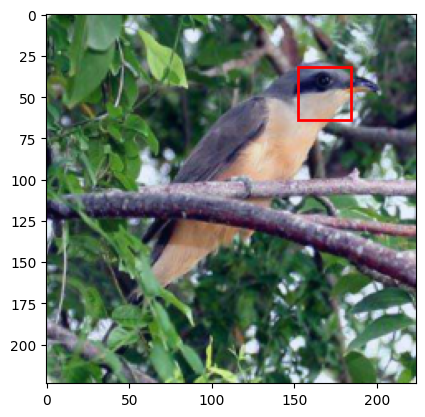

In [135]:
# brown and white head
LABEL = 8
I, BATCH_IDX, IMAGE = class_images[LABEL][0]
H_IDX, W_IDX = 4, 19
print('Label', LABEL)
print('Batch', I)
print('Within batch', BATCH_IDX)

# duck face
# LABEL = 1
# I, BATCH_IDX, IMAGE = class_images[LABEL][0]
# H_IDX, W_IDX = 4, 15
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# stick legs
# LABEL = 1
# I, BATCH_IDX, IMAGE = class_images[LABEL][0]
# H_IDX, W_IDX = 22, 11
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# black head
# LABEL = 3
# I, BATCH_IDX, IMAGE = class_images[LABEL][0]
# H_IDX, W_IDX = 4, 20
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# black tail
# LABEL = 3
# I, BATCH_IDX, IMAGE = class_images[LABEL][0]
# H_IDX, W_IDX = 12, 8
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# black duck head
# LABEL = 4
# I, BATCH_IDX, IMAGE = class_images[LABEL][0]
# H_IDX, W_IDX = 2, 8
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(
                img_size, softmaxes_shape, patchsize, skip, H_IDX, W_IDX
                )

IMAGE = IMAGE.permute(1, 2, 0)  # Convert image to (H, W, C) format
min_val = IMAGE.min()
max_val = IMAGE.max()
IMAGE = (IMAGE - min_val) / (max_val - min_val)

# Plot bounding box with the selected color
plt.imshow(IMAGE)
plt.gca().add_patch(
    plt.Rectangle(
        (w_coor_min, h_coor_min),
        w_coor_max - w_coor_min,
        h_coor_max - h_coor_min,
        fill=False,
        edgecolor='red',
        linewidth=2
    )
)
plt.show()

In [136]:
from pipnet.train import flatten_tensor

img_iter = tqdm(enumerate(projectloader),
                    total=len(projectloader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

BATCH_SIZE = projectloader.batch_size
all_features = torch.empty(0, 768).to(device)
for _i, (xs, ys) in img_iter:
    xs, ys = xs.to(device), ys.to(device)
    
#     # This filter is to check only among the same species, remove this if you wanna consider all species
#     if not ys.item() == LABEL:
#         continue
        
    with torch.no_grad():
        features, pfs, pooled, _ = net(xs, inference=True)
        flattened_features = flatten_tensor(features)
        all_features = torch.cat((all_features, flattened_features))

normalized_all_features  = F.normalize(all_features, p=2, dim=1)

In [137]:
print(normalized_all_features.shape)

torch.Size([365040, 768])


In [138]:
top_k = 10 # keep it a multiple of 5

normalized_all_features = normalized_all_features.cpu().numpy()

ref_vector = normalized_all_features[(I*BATCH_SIZE + BATCH_IDX)*(args.wshape ** 2) + H_IDX*args.wshape + W_IDX]
inner_products = np.dot(normalized_all_features, ref_vector)
sorted_indices = np.argsort(inner_products)[::-1]

top_k_indices = sorted_indices[:10]
top_k_vectors = normalized_all_features[top_k_indices]
top_k_inner_products = inner_products[top_k_indices]

In [139]:
# maps (i, batch_idx) to (h_idx, w_idx)
nearest_patches_indices = defaultdict(list)

for feature_idx in top_k_indices:
    _i = int((feature_idx / (args.wshape ** 2)) / BATCH_SIZE)
    
    _batch_idx = int((feature_idx / (args.wshape ** 2)) % BATCH_SIZE)
    _h_idx = int((feature_idx % (args.wshape ** 2)) / args.wshape)
    _w_idx = int((feature_idx % (args.wshape ** 2)) % args.wshape)
    
    nearest_patches_indices[(_i, _batch_idx)].append((_h_idx, _w_idx))
    
    print((_i, _batch_idx, _h_idx, _w_idx))

(240, 0, 4, 19)
(240, 0, 4, 18)
(240, 0, 4, 20)
(240, 0, 3, 19)
(240, 0, 5, 19)
(240, 0, 5, 18)
(265, 0, 4, 18)
(265, 0, 4, 17)
(240, 0, 3, 20)
(240, 0, 3, 18)


In [140]:
img_iter = tqdm(enumerate(projectloader),
                    total=len(projectloader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

img_list = []
bbox_list = []
for _i, (xs, ys) in img_iter:
    xs, ys = xs.to(device), ys.to(device)
    images, class_labels = xs, ys
    
#     # This filter is to check only among the same species, remove this if you wanna consider all species
#     if not ys.item() == LABEL:
#         continue
        
    for _batch_idx in range(len(class_labels)):
        label = class_labels[_batch_idx].item()
        image = images[_batch_idx]
                
        if (_i, _batch_idx) in nearest_patches_indices:
            image = image.permute(1, 2, 0)  # Convert image to (H, W, C) format
            min_val = image.min()
            max_val = image.max()
            image = (image - min_val) / (max_val - min_val)
            img_list.append(image.cpu().numpy())
            
            bboxes = []
            for _h_idx, _w_idx in nearest_patches_indices[(_i, _batch_idx)]:
                h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(
                    img_size, softmaxes_shape, patchsize, skip, _h_idx, _w_idx
                    )
                bboxes.append((h_coor_min, h_coor_max, w_coor_min, w_coor_max))
            bbox_list.append(bboxes)
            
            
print(len(img_list), len(img_list) == len(bbox_list))

2 True


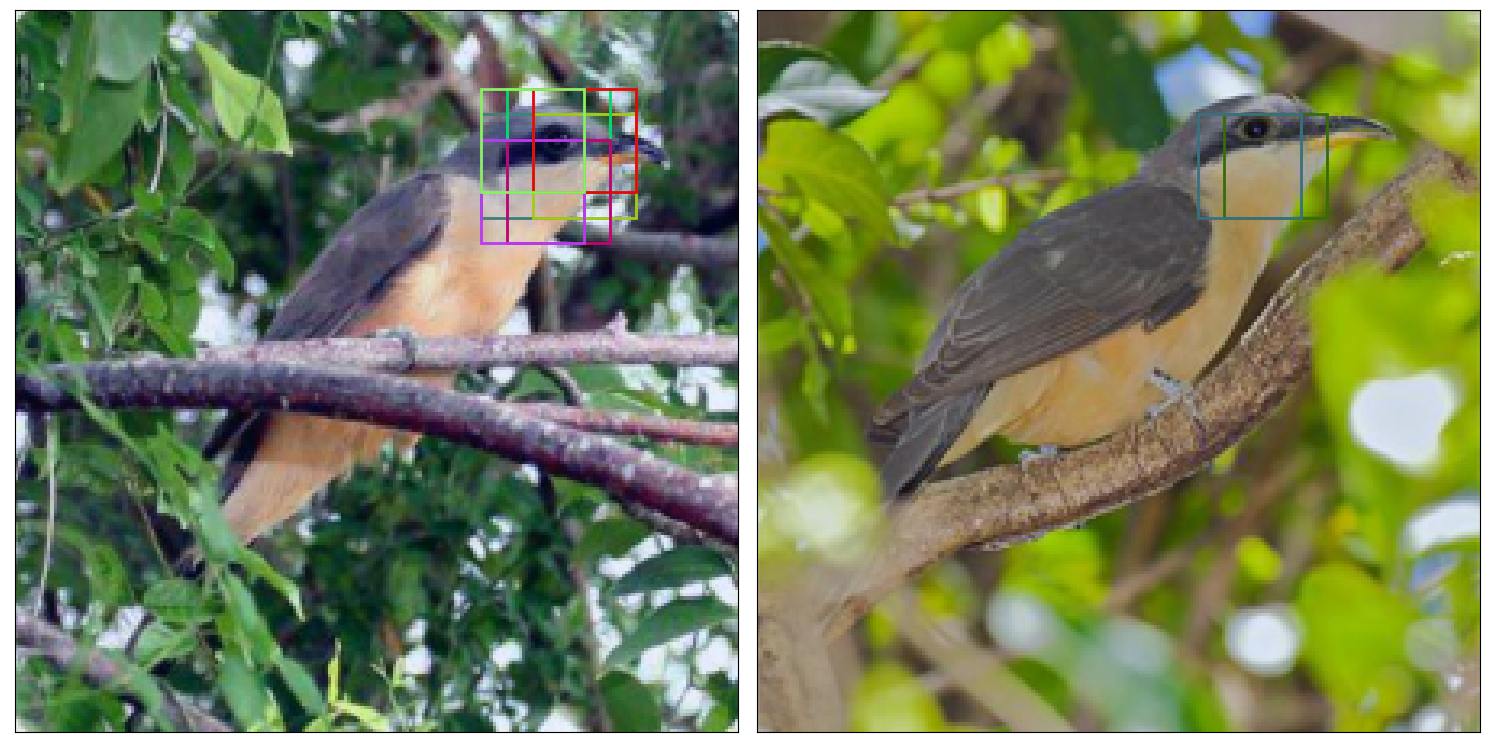

In [141]:
num_images = len(img_list)
num_rows = num_images // 5
if (num_images % 5) != 0:
    num_rows += 1
if num_images < 5:
    num_cols = num_images
else:
    num_cols = 5

# Create a figure and axis for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i, (image, bboxes) in enumerate(zip(img_list, bbox_list)):
    row_idx = i // num_cols
    col_idx = i % num_cols
    
    if num_images == 1:
        ax = axes
    elif num_rows > 1:
        ax = axes[row_idx, col_idx]
    else:
        ax = axes[col_idx]

    # Display the image
    ax.imshow(image)
    
    # Plot bounding boxes on the image
    for bbox in bboxes:
        h_coor_min, h_coor_max, w_coor_min, w_coor_max = bbox
        rect = plt.Rectangle(
            (w_coor_min, h_coor_min),
            w_coor_max - w_coor_min,
            h_coor_max - h_coor_min,
            fill=False,
            edgecolor=(random.random(), random.random(), random.random()),  # Random color
            linewidth=2
        )
        ax.add_patch(rect)

    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust spacing between subplots
plt.tight_layout()

# Show the grid of images with bounding boxes
plt.show()

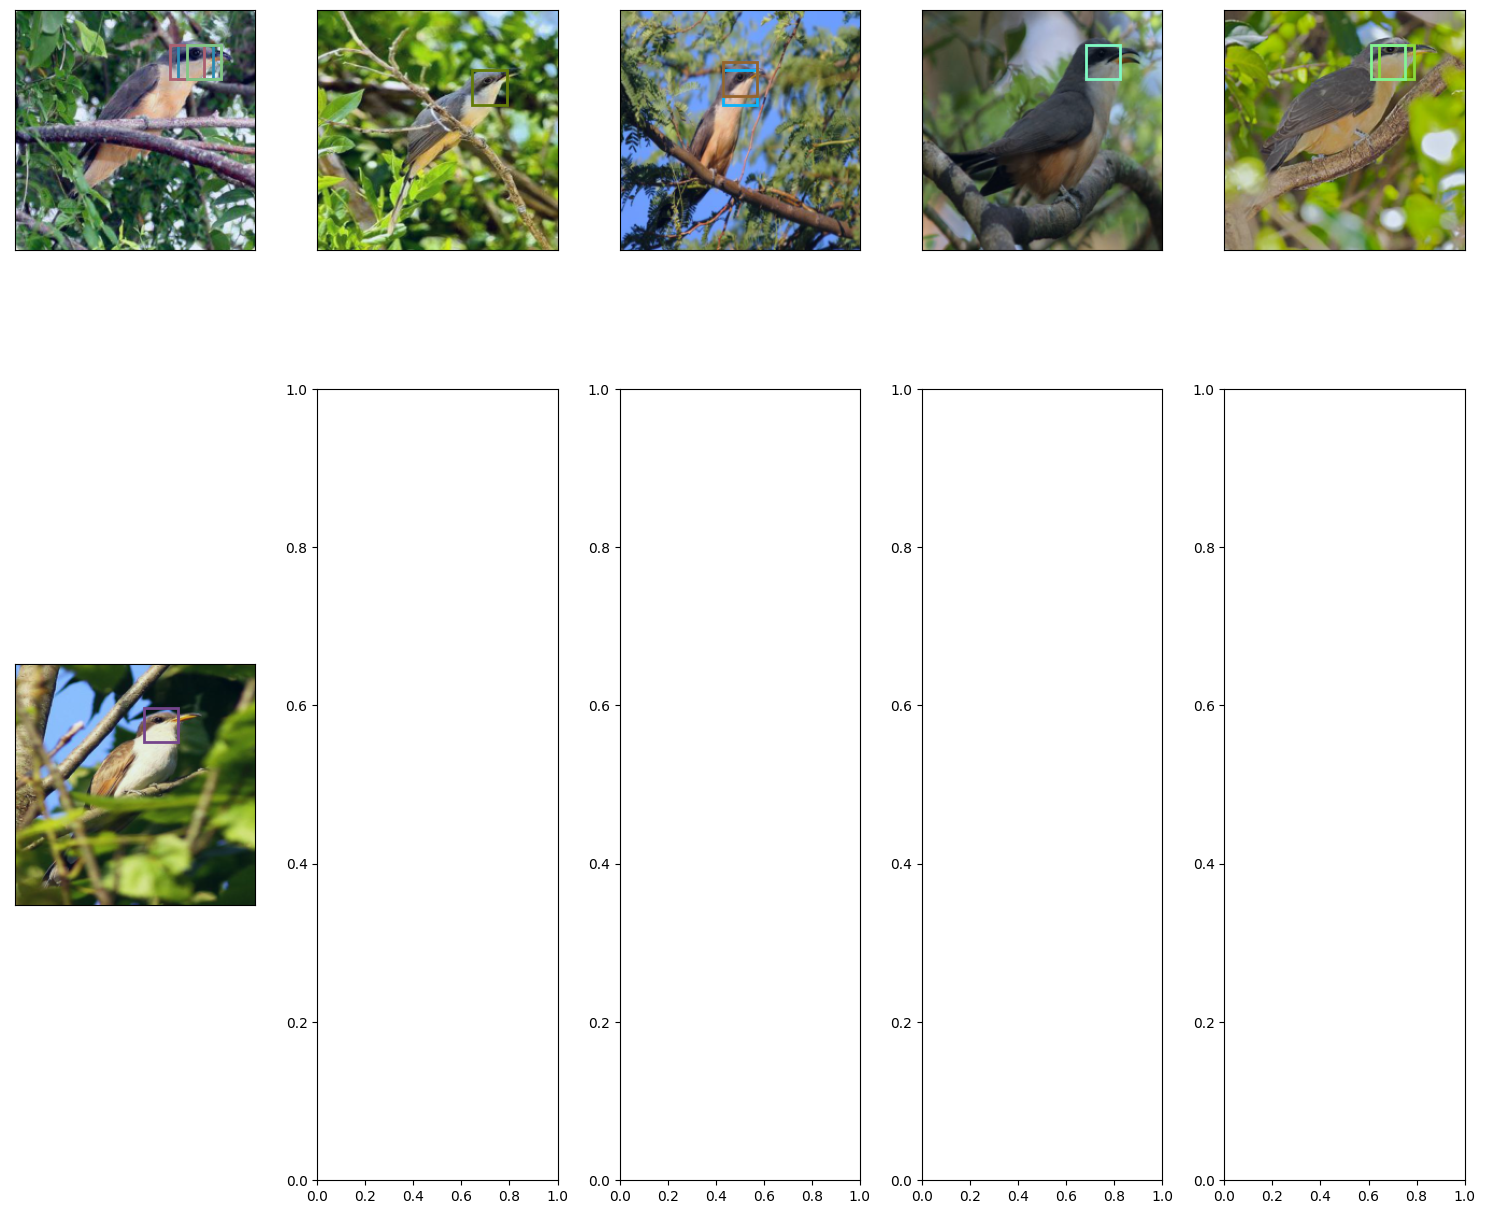

In [131]:
num_images = len(img_list)
num_rows = num_images // 5
if (num_images % 5) != 0:
    num_rows += 1
if num_images < 5:
    num_cols = num_images
else:
    num_cols = 5

# Create a figure and axis for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i, (image, bboxes) in enumerate(zip(img_list, bbox_list)):
    row_idx = i // num_cols
    col_idx = i % num_cols
    
    if num_images == 1:
        ax = axes
    elif num_rows > 1:
        ax = axes[row_idx, col_idx]
    else:
        ax = axes[col_idx]

    # Display the image
    ax.imshow(image)
    
    # Plot bounding boxes on the image
    for bbox in bboxes:
        h_coor_min, h_coor_max, w_coor_min, w_coor_max = bbox
        rect = plt.Rectangle(
            (w_coor_min, h_coor_min),
            w_coor_max - w_coor_min,
            h_coor_max - h_coor_min,
            fill=False,
            edgecolor=(random.random(), random.random(), random.random()),  # Random color
            linewidth=2
        )
        ax.add_patch(rect)

    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust spacing between subplots
plt.tight_layout()

# Show the grid of images with bounding boxes
plt.show()